In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
def dateconvert(datestring,fmt='%m/%d/%y'):
    #convert string to datetime object
    if isinstance(datestring,str):
        return dt.datetime.strptime(str(datestring),fmt)
    else:
        return [dt.datetime.strptime(str(ds),fmt) for ds in datestring]
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#this is the confirmed data, updated daily
raw_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df = pd.read_csv(raw_csv,header=0)
df.head()
col_before_dates = 'Long' #this is the last column before the dates start
print("Countries: {}".format(unique(df['Country/Region'])))

Countries: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Benin' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chile' 'China' 'Colombia' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cruise Ship' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt'
 'Equatorial Guinea' 'Estonia' 'Eswatini' 'Ethiopia' 'Finland' 'France'
 'Gabon' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Greenland' 'Guatemala'
 'Guernsey' 'Guinea' 'Guyana' 'Holy See' 'Honduras' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica'
 'Japan' 'Jersey' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kosovo'
 'Kuwait' 'Latvia' 'Lebanon' 'Liberia' 'Liechtenstein' 'Lithuania'
 'Luxembourg' 'Malays

In [3]:
## Choose the country and regin (if available)
country_name = 'Canada' #choose a single country by name (from list above)
province_subset = None #None for all provinces, or choose a subset of provinces as a list; e.g., ['Ontario','Quebec']
set_start_plotting_date = False #set to true if you would like to have plotting begin one day before a certain number of cases
case_thresh = 50 #case threshold

#generate the dataframe for the plotting
df_p = df[df['Country/Region']==country_name]
provinces = df_p['Province/State']
print("{} Province/State list: {}".format(country_name,list(provinces)))

Canada Province/State list: ['British Columbia', 'Ontario', 'Alberta', 'Quebec', 'New Brunswick', 'Manitoba', 'Saskatchewan', 'Grand Princess', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia']


In [4]:
#generate the dataframe for the plotting, if you provided a list for province_subset then this gets filtered here
if not df_p['Province/State'].isna().any(): 
    if province_subset is not None:
        df_p = df_p[df_p['Province/State'].isin(province_subset)]
    
if df_p.shape[0] == 0:
    print('Something has gone wrong!\nMost likely you did not spell the Country or Province/State name(s) correctly')
    
col_start_idx = df_p.columns.tolist().index(col_before_dates)+1

if df_p['Province/State'].isin(['Ontario','Quebec']).any():
    #social distancing date (ish, Quebec-based)
    social_distancing_date = '2020-03-12-12' #setbetween the 12th and 13th, as the policy came into effect on the 13th 
else:
    social_distancing_date = None
    
df_p.head()

if len(provinces) == 1:
    print('Country totals are the only data available for {}'.format(country_name))
    df_p_is_total = True
else:
    df_p_is_total = False
print("Regions: ")
print(provinces.values)

Regions: 
['British Columbia' 'Ontario' 'Alberta' 'Quebec' 'New Brunswick'
 'Manitoba' 'Saskatchewan' 'Grand Princess' 'Newfoundland and Labrador'
 'Prince Edward Island' 'Nova Scotia']


In [6]:
##generate a total and set this up for plotting, also create the ability to start the plot at a given date
#create a total, which causes issues due to ... pandas
if not df_p_is_total:
    df_total = df_p.sum()
    df_total = df_total.reset_index().T
    #silly pandas annoyances...
    t_x = dateconvert(df_total.iloc[0,col_start_idx:].tolist())
    t_y = np.array(df_total.iloc[1,col_start_idx:]).astype(int) 
else:
    t_x = dateconvert(df_p.iloc[:,col_start_idx:].columns)
    t_y = np.squeeze(df_p.iloc[:,col_start_idx:])

#setup a start date for plotting, in this case one time point prior to when we hit 50 cases in the country
if set_start_plotting_date:
    start_idx = np.where(t_y>case_thresh)[0][0]-1
else:
    start_idx = 0
    
t_x = t_x[start_idx:]
t_y = t_y[start_idx:]
# plot_start_date 

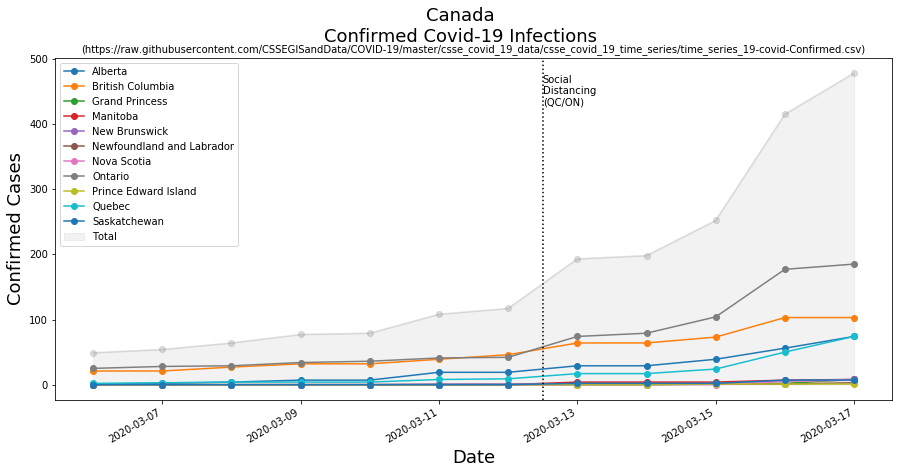

In [7]:
plt.figure(figsize=(15,7))
_t=plt.suptitle('{}\nConfirmed Covid-19 Infections'.format(country_name),fontsize=18)
_t=plt.title('({})'.format(raw_csv),fontsize=10)

plt.plot(t_x,t_y,'-o',color='grey',alpha=0.25)
plt.fill_between(t_x,t_y,interpolate=False,color='grey',alpha=0.1,label='Total')

if not df_p_is_total:
    for province in sort(unique(df_p['Province/State'])):
        df_pp = df_p[df_p['Province/State']==province]
        x = dateconvert(df_pp.iloc[:,col_start_idx+start_idx:].columns)
        y = np.squeeze(df_pp.iloc[:,col_start_idx+start_idx:])
        plt.plot(x,y,'o-',label=province)

#add the legend, but only if there are less than 20 lines on the plot
if len(unique(df_p['Province/State']))<=20: 
    plt.legend()
plt.gcf().autofmt_xdate()
_t=plt.xlabel("Date",fontsize=18)
_t=plt.ylabel("Confirmed Cases",fontsize=18)
if social_distancing_date is not None:
    _p=plt.axvline(x=social_distancing_date,color='k',linestyle=':')
    _t=plt.text(social_distancing_date,t_y.max()-50,"Social\nDistancing\n(QC/ON)")